### RNN 이해하기
 * RNN이라는 무엇일까?
 * RNN의 활용 예
 * RNN는 무엇의 약자일까?
 * 기존 신경망과 무엇이 다른가?
 * MNIST 데이터 셋을 어떻게 구현할까?

### RNN의 용어 이해
 * 순환 신경망(Recurrent Neural Network)이다.
 * RNN은 상태가 고정된 데이터를 처리하는 다른 신경망과 달리 자연어 처리나 음성 인식처럼 순서가 있는 데이터를 처리하는 데 강점이 있다.
 * RNN은 자연어 처리나 음성 인식처럼 순서가 있는 데이터를 처리하는 강점이 있음.
 
 <br>

 * 예를 들어, "우와~ 오늘 드라마 참 재밌네"와 "망했다! 드라마 참 재밌네"의 문장.
 * 앞이나 뒤의 정보에 따라 전체의 의미가 달라질 때,
 * 앞의 정보로 다음에 나오는 정보를 추측하려고 할 때, RNN을 사용하면 좋은 프로그램을 만들 수 있다.
 * 2016년 구글의 신경망 기반 기계 번역이 RNN을 이용하여 만든 서비스이다.
    * 구글에서는 이 신경망을 이용하여 수개월만에 제공하던 통계 기반 번역 서비스의 성능을 한참 넘을 수 있었다.

In [1]:
import os, warnings
# 이미지 처리 분야에서 가장 유명한 신경망 모델인 CNN 을 이용
import tensorflow as tf
import time
from IPython.display import display, Image

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 경고 메시지 무시하거나 숨길때(ignore), 다시보이게(default)
# warnings.filterwarnings(action='default')
warnings.filterwarnings(action='ignore')

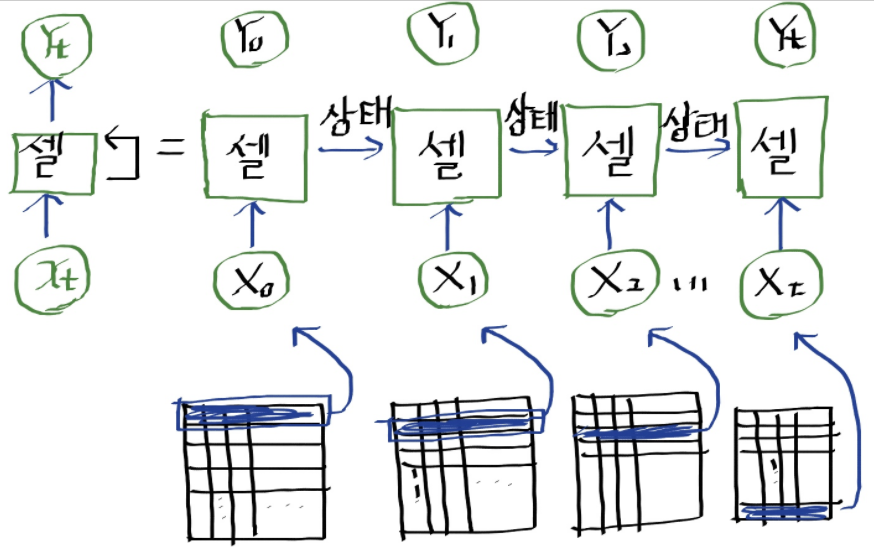

In [3]:
display(Image(filename="../img/Rnn.png"))

### RNN의 구조 이해
* 그림의 한가운데 있는 한 덩어리의 신경망을 셀(cell)이라고 한다.
* RNN은 셀을 여러개 중첩하여 심층 신경망을 만든다.
* 앞의 학습 결과를 다음 단계의 학습에 이용한다. 
* 학습 데이터를 단계별로 구분하여 입력을 한다.
* MNIST를 RNN에 적용한다고 하면, 한 줄단위(28픽셀)을 한 단계의 입력값으로 한다. 총 28단계를 거쳐 입력받음.

### 기본 개념
* 그림의 한가운데 있는 한 덩어리의 신경망을 셀(cell)이라고 한다.
* RNN은 이 셀을 여러개 중첩하여 심층 신경망을 만든다.
* 앞 단계의 학습 결과를 다음 단계의 학습에 사용. 
   * 학습 데이터를 단계별로 구분하여 입력을 해야 함.

In [6]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [7]:
############
# 옵션 설정
############
learning_rate = 0.001
total_epoch = 20
batch_size = 128

## RNN은 순서가 있는 자료를 다루므로,
## 한 번에 입력받는 갯수와, 총 몇 단계로 이루어져있는 
## 데이터를 받을지를 설정해야함.

## 이미지의 경우, 
## 가로 픽셀수를 n_input 으로, 
## 세로 픽셀수를 입력 단계인 n_step 으로 설정.

n_input = 28   # 입력
n_step = 28    # 28단계 ( 28 X 28)
n_hidden = 128 # 은닉층 노드 수 : 128
n_class = 10   # 클래스 : 10

### 신경망 모델 구성
* RNN은 순서가 있는 데이터를 다룬다. 한번에 입력받을 데이터 개수와 총 몇 단계로 이뤄진 데이터를 받을 지 설정해야 함.
* 가로 픽셀 수 : n_input (데이터가 들어가는 개수의 크기)
* 세로 픽셀 수 : n_step (단계)
* 출력값은 원핫 인코딩으로 표현

In [8]:
X = tf.placeholder(tf.float32, [None, n_step, n_input])  # n_step 차원을 추가
Y = tf.placeholder(tf.float32, [None, n_class])

In [9]:
#W = tf.Variable(tf.random_normal([n_hidden, n_class]))
#b = tf.Variable(tf.random_normal([n_class]))

### Tensorflow에서 함수 제공하여 간단하게 RNN 셀 생성
 * RNN의 기본 신경망은 다양한 방식의 셀을 사용할 수 있는 함수를 제공
 * RNN의 기본 신경망은 긴 단계의 데이터를 학습할 때 맨 뒤에서는 맨 앞의 정보를 잘 기억하지 못함.
 * 가장 많이 사용하는 것이 LSTM(Long Short-Term Memory)의 신경망
 * GRU(Gated Recurrent Units) 약간 간단한 신경망. LSTM과 비슷. 구조가 좀 더 간단한 신경망

In [12]:
# RNN 에 학습에 사용할 셀을 생성합니다
# 다음 함수들을 사용하면 다른 구조의 셀로 간단하게 변경할 수 있습니다
# BasicRNNCell,BasicLSTMCell,GRUCell
cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)

* dynamic_rnn 함수를 이용하여 RNN 신경망 완성
* 한 단계를 학습 후, 상태를 저장, 그 상태를 다음 단계의 입력상태로 하여 다시 학습.
* 이를 반복하여 출력값을 만들어간다. RNN의 기본 구조

In [13]:
cell

### 반복과정
```
states = tf.zeros(batch_size)
for i in range(n_step):
    outputs, states = cell(X[[:, i]], states)
...
다음처럼 tf.nn.dynamic_rnn 함수를 사용하면
CNN 의 tf.nn.conv2d 함수처럼 간단하게 RNN 신경망을 만들어줍니다.
```
* 한 단계를 학습한 뒤, 상태를 저장한다. 
* 그 상태를 다음 단계의 입력 상태로 하여 다시 학습한다.
* 주어진 단계만큼 반복하면서 상태를 전파하며 출력값을 만들어간다. RNN의 기본 구조
* 이에 대한 전 단계를 고려하며 RNN의 모델의 핵심 구조를 만들 수 있는 것이 dynamic_rnn함수이다.

In [15]:
# 에러 발생시, restart kernel 수행
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [16]:
print(outputs)
print(states)

Tensor("rnn_1/transpose_1:0", shape=(?, 28, 128), dtype=float32)
Tensor("rnn_1/while/Exit_3:0", shape=(?, 128), dtype=float32)


In [17]:
W = tf.Variable(tf.random_normal([n_hidden, n_class]))
b = tf.Variable(tf.random_normal([n_class]))

## 최종 모델 만들기

* RNN 신경망이 출력값의 형태 -> [batch_size, n_step, n_hidden]
  * batch_size : 데이터의 개수
  * n_step : RNN의 단계
  * n_hidden : 은닉층의 노드 수
* 우리는 위의 형태를 가중치(W)의 형태로 변경해 주어야 한다.
  * (가) 순서 바꾸기 :  [batch_size, n_step, n_hidden]  -> [n_step, batch_size, n_hidden]
  * (나) n_step의 차원을 제거 [batch_size, n_hidden]

* 최종 결과가 실측값과 동일한 형태를 가져야 함.
* outputs : [batch_size, n_step, n_hidden] 
* 앞에서 이 형태의 출력값을 만들기 위해 가중치와 편향을 설정

In [18]:
# --> W = tf.Variable(tf.random_normal([n_hidden, n_class]))
# --> b = tf.Variable(tf.random_normal([n_class]))

* 결과를 Y의 다음 형식과 바꿔야 하기 때문에
   * Y : [batch_size, n_class]
        
* RNN 신경망에서 나오는 출력값
   * -> [batch_size, n_step, n_hidden] 
   * -> [n_step, batch_size, n_hidden]

* tf.transpose 함수를 이용하여 n_step과 batch_size의 차원의 순서를 바꾸고, 
* n_step 차원을 제거하여 마지막 단계의 결과값을 취함.

In [19]:
print(outputs)

Tensor("rnn_1/transpose_1:0", shape=(?, 28, 128), dtype=float32)


In [20]:
# [batch_size, n_step, n_hidden]  -> [n_step, batch_size, n_hidden]
print("start 01 : ", outputs)
outputs = tf.transpose(outputs, [1, 0, 2])
print("start 02 : ", outputs)
#  -> [batch_size, n_hidden]의 형태로 변경
outputs = outputs[-1]
print("start 03 : ", outputs)
# y = x * W + b를 이용하여 최종 결과값. 
model = tf.matmul(outputs, W) + b
print(model)

start 01 :  Tensor("rnn_1/transpose_1:0", shape=(?, 28, 128), dtype=float32)
start 02 :  Tensor("transpose:0", shape=(28, ?, 128), dtype=float32)
start 03 :  Tensor("strided_slice:0", shape=(?, 128), dtype=float32)
Tensor("add:0", shape=(?, 10), dtype=float32)


In [21]:
print(outputs)
print(model)

Tensor("strided_slice:0", shape=(?, 128), dtype=float32)
Tensor("add:0", shape=(?, 10), dtype=float32)


### cost, optimizer 지정

In [22]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### 신경망 모델 학습

In [23]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size)

In [24]:
### 데이터 확인
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

(55000, 784)
(55000, 10)


In [25]:
# total_epoch : 30
# batch_size : 128
# n_step : 28
# n_input : 28
for epoch in range(total_epoch):
    total_cost = 0

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        if (i==0 and epoch==0):
            print("입력 : {}, 출력 : {}".format(batch_xs.shape, batch_ys.shape))
            
        # X 데이터를 RNN 입력 데이터에 맞게 
        # [batch_size, n_step, n_input] 형태로 변환합니다.
        batch_xs = batch_xs.reshape((batch_size, n_step, n_input))

        if (i==0 and epoch==0):
            print("입력 : {}, 출력 : {}".format(batch_xs.shape, batch_ys.shape))  
            
        _, cost_val = sess.run([optimizer, cost],
                               feed_dict={X: batch_xs, Y: batch_ys})
        
        total_cost += cost_val

    print('Epoch:', '%04d' % (epoch + 1),
          'Avg. cost =', '{:.3f}'.format(total_cost / total_batch))

print('최적화 완료!')

입력 : (128, 784), 출력 : (128, 10)
입력 : (128, 28, 28), 출력 : (128, 10)
Epoch: 0001 Avg. cost = 0.567
Epoch: 0002 Avg. cost = 0.249
Epoch: 0003 Avg. cost = 0.190
Epoch: 0004 Avg. cost = 0.166
Epoch: 0005 Avg. cost = 0.146
Epoch: 0006 Avg. cost = 0.139
Epoch: 0007 Avg. cost = 0.122
Epoch: 0008 Avg. cost = 0.119
Epoch: 0009 Avg. cost = 0.109
Epoch: 0010 Avg. cost = 0.107
Epoch: 0011 Avg. cost = 0.100
Epoch: 0012 Avg. cost = 0.094
Epoch: 0013 Avg. cost = 0.097
Epoch: 0014 Avg. cost = 0.094
Epoch: 0015 Avg. cost = 0.085
Epoch: 0016 Avg. cost = 0.087
Epoch: 0017 Avg. cost = 0.084
Epoch: 0018 Avg. cost = 0.083
Epoch: 0019 Avg. cost = 0.078
Epoch: 0020 Avg. cost = 0.078
최적화 완료!


### 결과 확인

In [19]:
#########
# 결과 확인
######
is_correct = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print(is_correct)
print(accuracy)

Tensor("Equal:0", shape=(?,), dtype=bool)
Tensor("Mean_1:0", shape=(), dtype=float32)


In [20]:
# test_batch_size : 10000, n_step : 28, n_input : 28
test_batch_size = len(mnist.test.images)
test_xs = mnist.test.images.reshape(test_batch_size, n_step, n_input)
test_ys = mnist.test.labels

In [21]:
print(test_batch_size)
print(test_xs)
print(test_ys)

10000
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[0.

In [22]:
print('정확도:', sess.run(accuracy,
                       feed_dict={X: test_xs, Y: test_ys}))

정확도: 0.9714


#### 손글씨 인식 결과 97%의 결과. Awesome!!!

### REF 
* 골빈 해커의 3분 딥러닝